In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus as pdp
from six import StringIO 
from IPython.display import Image  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score




In [156]:
dataframe = pd.read_csv("types_stats_data.csv")

dataframe.isna().sum()

type1           0
type2         384
hp              0
attack          0
defense         0
speed           0
sp_attack       0
sp_defense      0
dtype: int64

To better fit the data into a Logistic Regression Model, we're going to combine the type1 and type2 columsn by adding a duplicate entry for any pokemon with doouble types except with their secondary type as their primary. This also gives about another 400 data points to work with, and should slightly boost the models effectivenss.

In [157]:
double_type_dataframe = dataframe.dropna()

for index, row in double_type_dataframe.iterrows():
    if type(row["type2"]) == float: continue
   
    dataframe.loc[dataframe.shape[0] + 1] = [row["type2"], pd.NA, row["hp"], row["attack"], row["defense"], row["speed"], row["sp_attack"], row["sp_defense"]]

dataframe.tail()

,type1,type2,hp,attack,defense,speed,sp_attack,sp_defense
1214,fighting,NaN,71,137,37,151,137,37
1215,flying,NaN,97,101,103,61,107,101
1216,steel,NaN,59,181,131,109,59,31
1217,dragon,NaN,223,101,53,43,97,53
1218,fairy,NaN,80,95,115,65,130,115


In [158]:
x = dataframe[["hp","defense","attack","speed","sp_defense","sp_attack"]]
y = dataframe["type1"]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

With Precision, Accuracy, and Recall scores all around the 0.15 mark it's clear that there is very little correlation between the stats and the types of the pokemon. The heatmap of the cofusion matrix shows that while some types are sliightly more likely to be predicted correctly, generally types are precicted incorrectly and almost at random.

Precision: 0.150097636547162
Accuracy: 0.1598360655737705
Recall: 0.1598360655737705
F1 Score: 0.13522064279357457


/home/elfy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: >

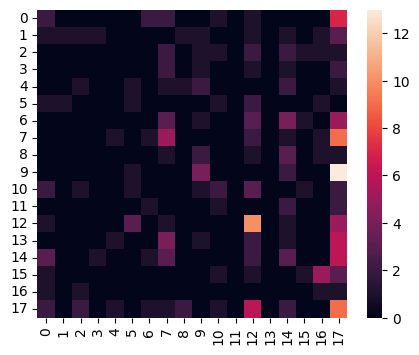

In [159]:
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(x_train,y_train)


y_pred = log_reg_model.predict(x_test)

vconfusion_matrix = confusion_matrix(y_test, y_pred)
vprecision_score = precision_score(y_test, y_pred, average='weighted')
vaccuracy_score = accuracy_score(y_test, y_pred)
vrecall_score = recall_score (y_test, y_pred, average='weighted')
vf1_score = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {vprecision_score}\nAccuracy: {vaccuracy_score}\nRecall: {vrecall_score}\nF1 Score: {vf1_score}")
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['figure.dpi'] = 100
sns.heatmap(vconfusion_matrix)

As this is a classification problem, we could also attempt to use a Decision Tree or KMeans. Below is the Decision Tree generated using all deafeault values. It is quite clearly very large, and has a large number of node. It has so many nodes that it almost seems too many given there were only 740 elements in the training data.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.347377 to fit



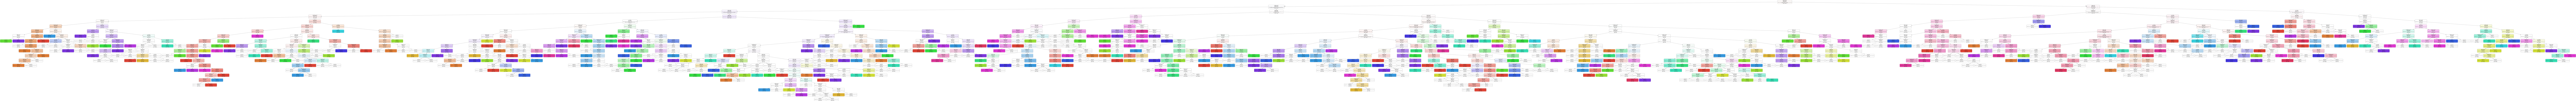

In [160]:
dec_tree_model = DecisionTreeClassifier()
dec_tree_model.fit(x_train,y_train)

plt.rcParams['figure.figsize'] = (20, 18)
plt.rcParams['figure.dpi'] = 100

dot_data = StringIO()
export_graphviz(dec_tree_model, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=["hp","defense","attack","speed","sp_defense","sp_attack"], class_names=dec_tree_model.classes_)
graph = pdp.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

Our previous observation that the Decision Tree was too complicated is validated below. There are more desicions in the tree than their are possible outcomes in the training data. And very nearly as many leaves. It seems very likely that the tree has massively overfitted to the training data and by comparing it's prediction for the test and training data, we can see that this is true, as out evaluation metrics are significatly higher on the train data than the test data.

In [168]:
y_pred_test = dec_tree_model.predict(x_test)
y_pred_train = dec_tree_model.predict(x_train)

test_accuracy_score = accuracy_score(y_test, y_pred_test)
test_precision_score = precision_score(y_test, y_pred_test, average="weighted")
test_recall_score = recall_score(y_test, y_pred_test, average="weighted")

train_accuracy_score = accuracy_score(y_train, y_pred_train)
train_precision_score = precision_score(y_train, y_pred_train, average="weighted")
train_recall_score = recall_score(y_train, y_pred_train, average="weighted")

num_leaves = dec_tree_model.get_n_leaves()
num_nodes = dec_tree_model.tree_.node_count
tree_depth = dec_tree_model.get_depth()

print(f"Model Evaluation:\nTest_Accuracy: {test_accuracy_score:.2}\nTest_Precision: {test_precision_score:.2}\nTest_Recall: {test_recall_score:.2}\n")
print(f"Train Accuracy: {train_accuracy_score:.2}\nTrain_Precision: {train_precision_score:.2}\nTrain Recall: {train_recall_score:.2}\n")
print(f"Model Parameters:\nTree Depth: {tree_depth}\nNode Num: {num_nodes}\nLeaves Num {num_leaves}")

Model Evaluation:
Test_Accuracy: 0.094
Test_Precision: 0.12
Test_Recall: 0.094

Train Accuracy: 0.72
Train_Precision: 0.77
Train Recall: 0.72

Model Parameters:
Tree Depth: 20
Node Num: 1163
Leaves Num 582
